In [2]:
import os
from pathlib import Path, PureWindowsPath
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Import Data

In [4]:
os.path.dirname(os.getcwd())

'C:\\Users\\cyl1220\\Desktop\\Store-Sales'

In [5]:
path_cwd = Path(PureWindowsPath(os.path.dirname(os.getcwd())))
path_cwd

WindowsPath('C:/Users/cyl1220/Desktop/Store-Sales')

In [6]:
path = path_cwd / 'data'
path

WindowsPath('C:/Users/cyl1220/Desktop/Store-Sales/data')

In [7]:
df_train = pd.read_csv(path / 'train.csv')
df_transaction = pd.read_csv(path / 'transactions.csv')
df_holidays = pd.read_csv(path / 'holidays_events.csv')
df_oil = pd.read_csv(path / 'oil.csv')
df_stores = pd.read_csv(path / 'stores.csv')
df_test = pd.read_csv(path / 'test.csv')

In [693]:
df_train.dtypes

id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
day                     int32
day_of_week             int32
day_name               object
month                   int32
year                    int32
dtype: object

In [181]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [182]:
df_test = pd.read_csv(path / 'test.csv')
df_test

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


# Clean Data

In [183]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [184]:
print('max:',df_train['date'].max(), 'min:',df_train['date'].min())

max: 2017-08-15 min: 2013-01-01


In [185]:
df_train['date'] = pd.to_datetime(df_train['date'])

In [186]:
#add time element features
df_train['day'] = df_train['date'].dt.day
df_train['day_of_week'] = df_train['date'].dt.dayofweek
df_train['day_name'] = df_train['date'].dt.day_name()
#df_train['week'] = df_train['date'].dt.isocalendar().week
df_train['month'] = df_train['date'].dt.month
df_train['year'] = df_train['date'].dt.year


## Check for seasonality

In [187]:
df_daily_sales = df_train.groupby('date')['sales'].sum().reset_index()
df_monthly_sales = df_train.groupby(['year','month'])['sales'].sum().reset_index()
df_monthly_sales_by_store = df_train.groupby(['year','month', 'store_nbr'])['sales'].sum().reset_index()

In [188]:
#use rolling avg for SARIMA? maybe not
df_daily_sales['rolling_average_7_day'] = df_daily_sales['sales'].rolling(window=7).mean() 

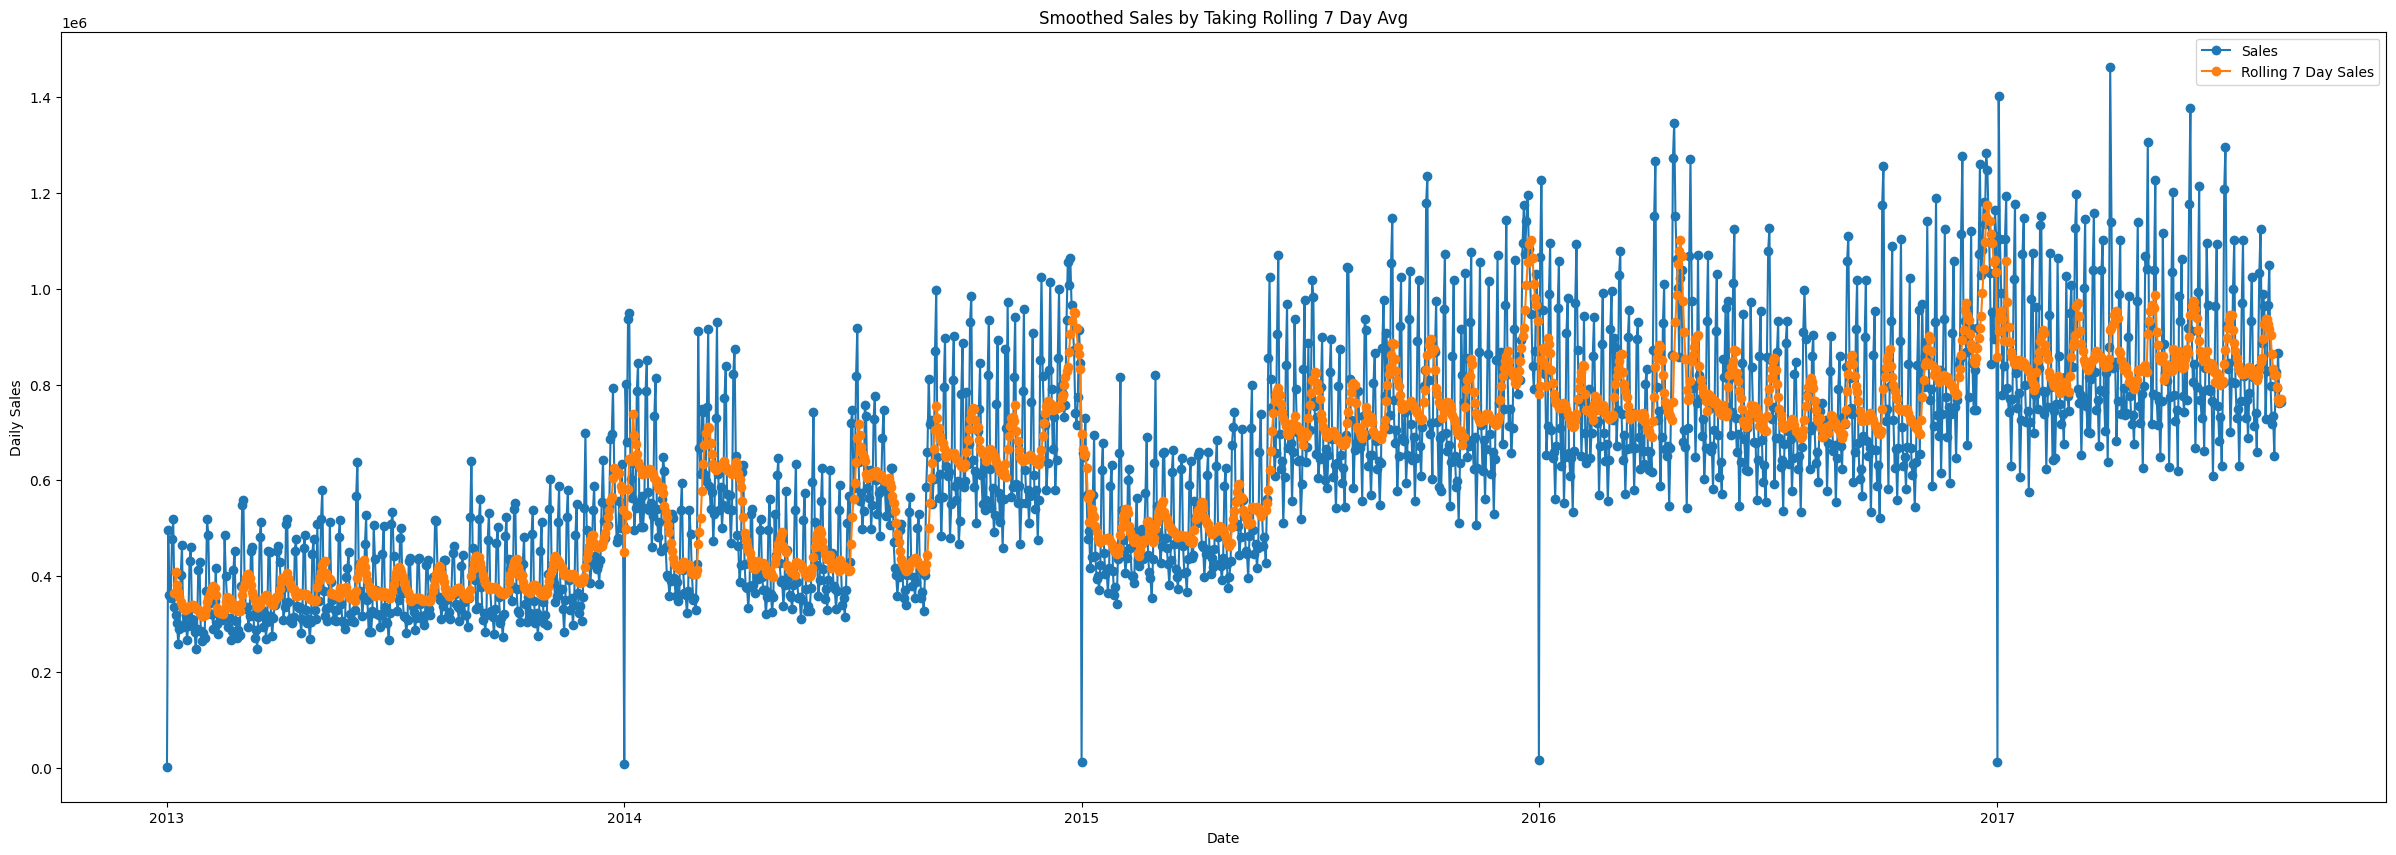

In [189]:

plt.figure(figsize=(30, 10))
plt.plot(df_daily_sales['date'] , df_daily_sales['sales'], label='Sales', marker='o') #, marker='o', color='year')
plt.plot(df_daily_sales['date'] , df_daily_sales['rolling_average_7_day'], label='Rolling 7 Day Sales', marker='o')
#sns.barplot(x=df_monthly_sales['year'].astype(str)+'-'+df_monthly_sales['month'].astype(str), y='sales', hue='year', data=df_monthly_sales, palette='viridis')
plt.xlabel('Date')
plt.ylabel('Daily Sales')
plt.title('Smoothed Sales by Taking Rolling 7 Day Avg')
plt.legend()
plt.show()

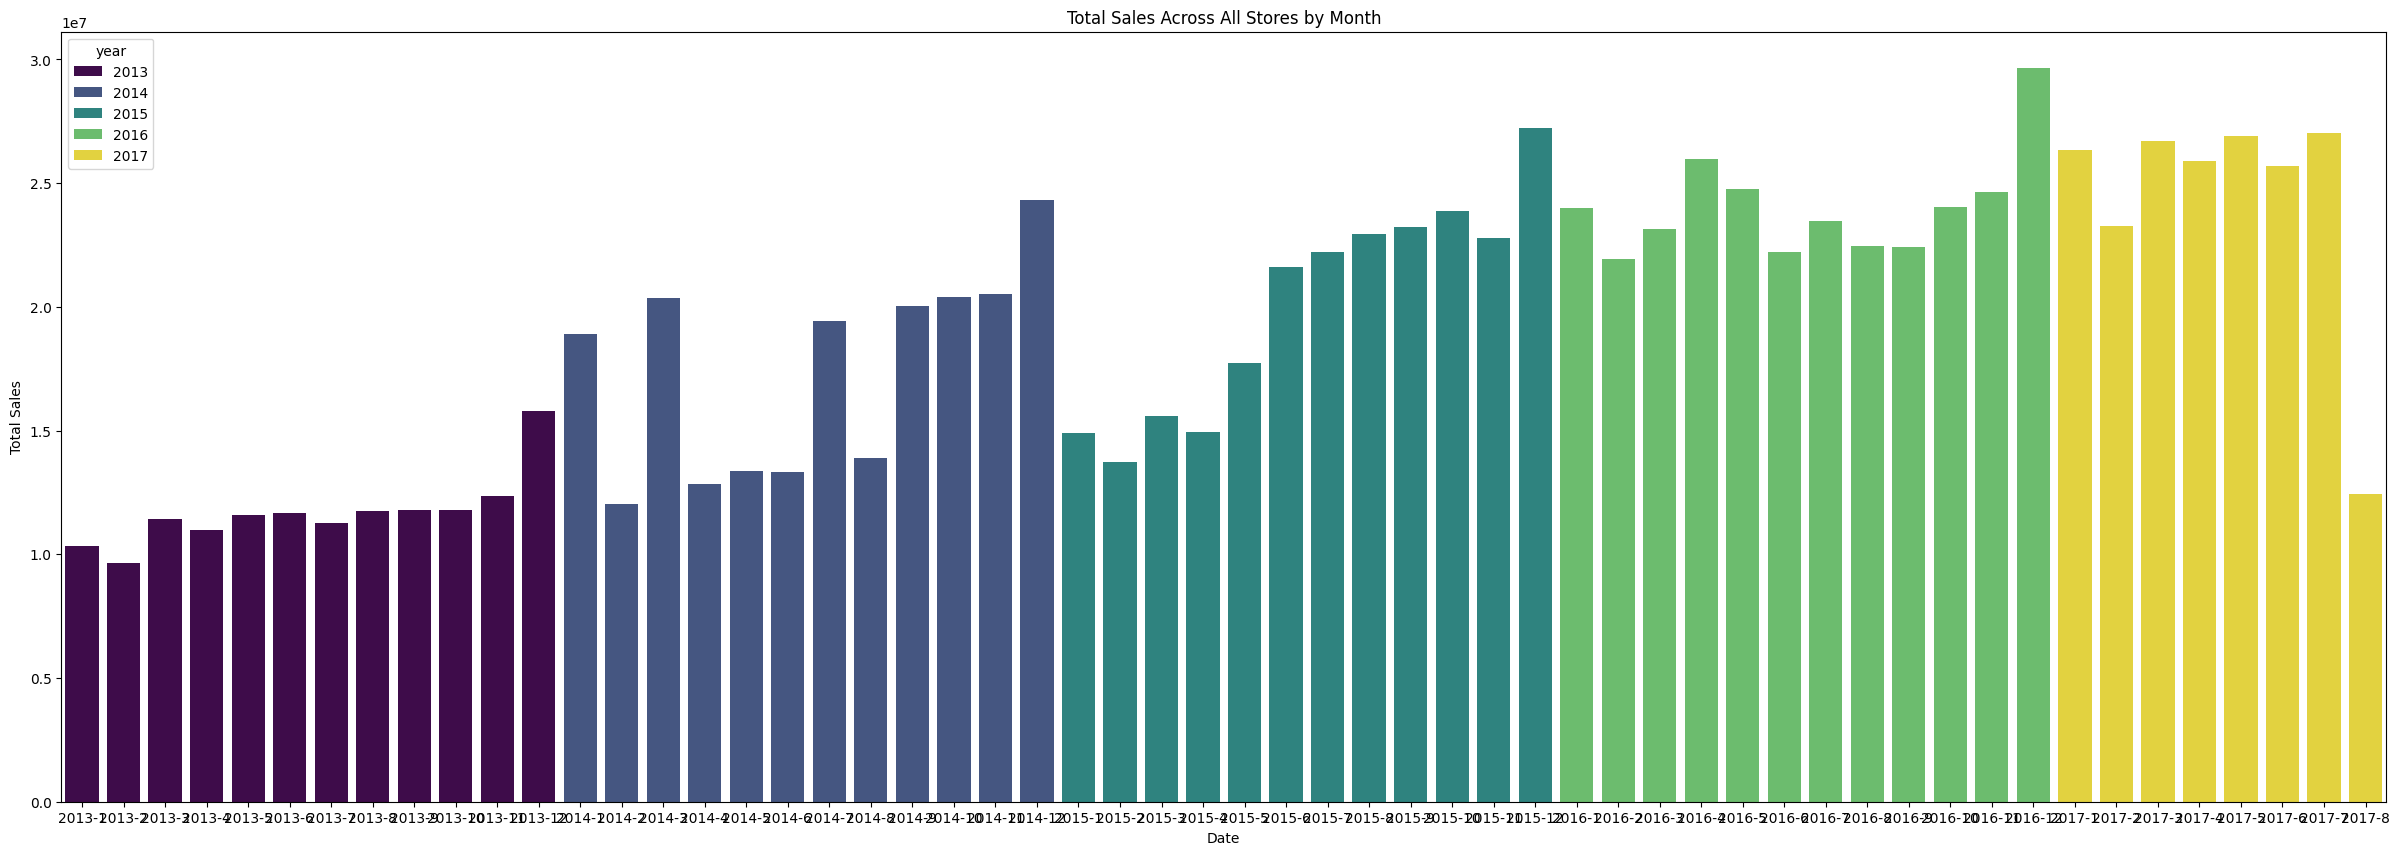

In [190]:
plt.figure(figsize=(30, 10))
#plt.plot(df_monthly_sales['year'].astype(str)+'-'+df_monthly_sales['month'].astype(str) , df_monthly_sales['sales'], marker='o', color='year')
sns.barplot(x=df_monthly_sales['year'].astype(str)+'-'+df_monthly_sales['month'].astype(str), y='sales', hue='year', data=df_monthly_sales, palette='viridis')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Total Sales Across All Stores by Month')
plt.show()

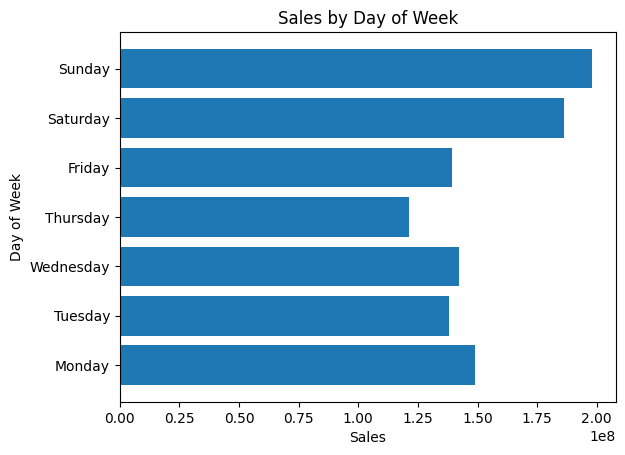

In [191]:
dow_sales = df_train.groupby('day_name')['sales'].sum().reset_index()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

dow_sales['day_name'] = pd.Categorical(dow_sales['day_name'], categories=day_order, ordered=True)
dow_sales.sort_values('day_name', inplace=True)

plt.barh(dow_sales['day_name'], dow_sales['sales'])
plt.xlabel('Sales')
plt.ylabel('Day of Week')
plt.title('Sales by Day of Week')
plt.show()

there is significant seasonality across days of the week and months in the year. Ex. Sunday and December both usually will have high sales

## check for missing values

In [192]:
### there are stores that werent open in 2013. it would be better to remove those rows

In [193]:
mindate = df_train[df_train['date']=='2013-01-01']
maxdate = df_train[df_train['date']=='2017-08-15']

print(mindate.shape[0], 'rows in the lowest date. ', maxdate.shape[0], 'rows in the max date')

1782 rows in the lowest date.  1782 rows in the max date


In [194]:
rows_per_day = df_train.groupby('date').size()
rows_per_day[rows_per_day!= 1782]

Series([], dtype: int64)

Every day has 1782 entries. That means that there are no missing values for id, store_nbr, or family. If there were no sales, the row will contain a 0 sales value

In [ ]:
series_all_dates = df_train['date'].unique()
df_all_dates = pd.DataFrame(series_all_dates)
df_all_dates.to_csv(r'df_all_dates.csv', index=False)  # Set index=False if you don't want to include row numbers in the CSV file
#use this to find missing dates. Xmas is only date missing

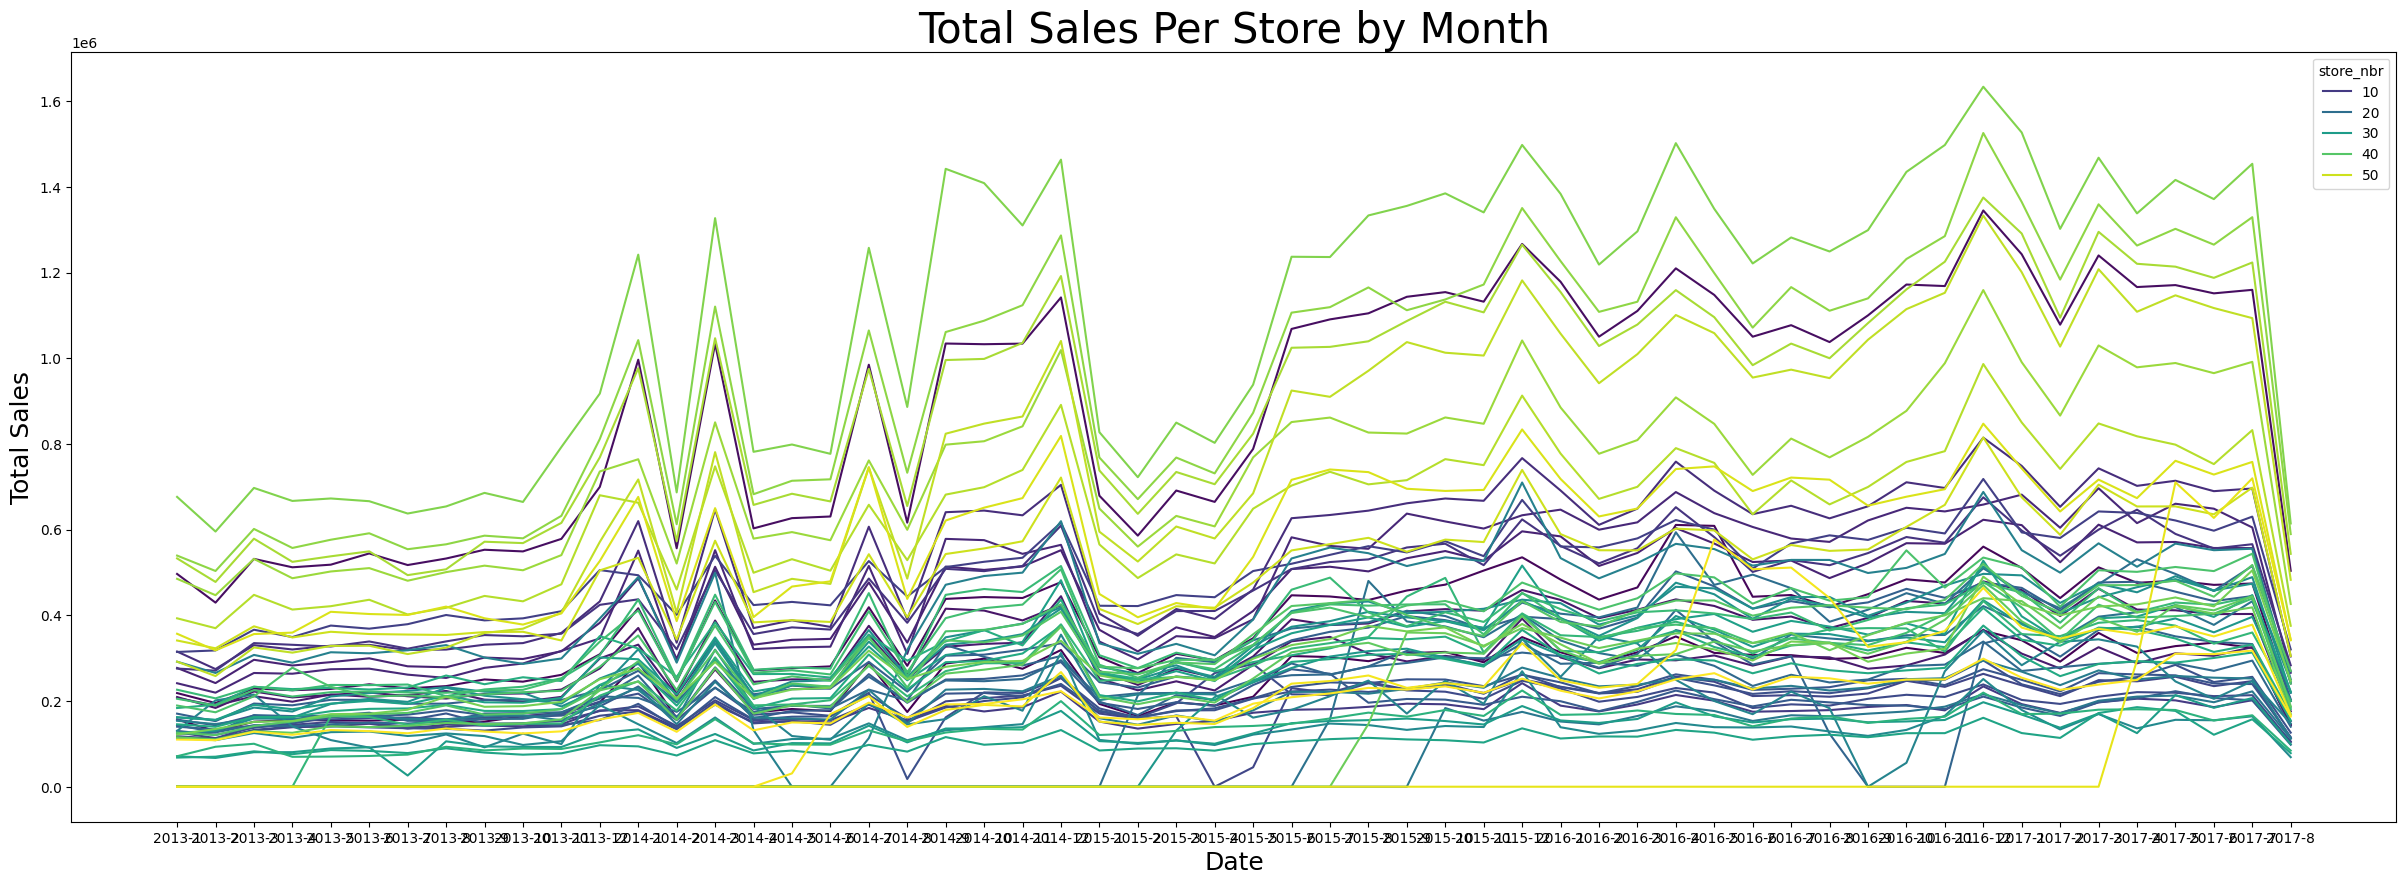

In [705]:
plt.figure(figsize=(30, 10))
#plt.plot(df_monthly_sales['year'].astype(str)+'-'+df_monthly_sales['month'].astype(str) , df_monthly_sales['sales'], marker='o', color='year')
sns.lineplot(x=df_monthly_sales_by_store['year'].astype(str)+'-'+df_monthly_sales_by_store['month'].astype(str), y='sales', hue='store_nbr', data=df_monthly_sales_by_store, palette='viridis')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Total Sales', fontsize=18)
plt.title('Total Sales Per Store by Month', fontsize=30)
plt.show()

In [196]:
#check for stores and categories with 0 sales. remove those rows. 
#certain stores wont have opened in 2013 and certain store probably dont sell certain items?? bad assumption?
df_train.head()
unique_stores = df_train['store_nbr'].drop_duplicates().sort_values()
unique_stores.count()

54

In [197]:
first_sale_date_per_store = df_train[df_train['sales'] > 0].groupby('store_nbr')['date'].min().reset_index()
first_sale_date_per_store

,store_nbr,date
0,1,2013-01-02
1,2,2013-01-02
2,3,2013-01-02
3,4,2013-01-02
4,5,2013-01-02
5,6,2013-01-02
6,7,2013-01-02
7,8,2013-01-02
8,9,2013-01-02
9,10,2013-01-02


In [659]:
def train_to_store_merge(train, store):
    df_train_store_merged = pd.merge(train, store, how='left', on='store_nbr')
    return df_train_store_merged


In [661]:
df_train_min_date = pd.merge(df_train, first_sale_date_per_store, on='store_nbr')
df_train_shortened = df_train_min_date[df_train_min_date['date_x'] >= df_train_min_date['date_y']] 
df_train_shortened = df_train_shortened.drop(['date_y'], axis=1)
df_train_shortened.rename(columns={'date_x':'date'}, inplace=True)
df_train_shortened = train_to_store_merge(df_train_shortened, df_stores)
df_train_shortened
### store 25 was closed from 2016-08-23 to 2016-10-26. remove these rows
## store 16 was closed from 2016-08-15 to 2016-12-02. remove these rows
# store 24 was closed from 2014-04-14 to 2014-07-23

,id,date,store_nbr,family,sales,onpromotion,day,day_of_week,day_name,month,year,city,state,type,cluster
0,1782,2013-01-02,1,AUTOMOTIVE,2.000,0,2,2,Wednesday,1,2013,Quito,Pichincha,D,13
1,1783,2013-01-02,1,BABY CARE,0.000,0,2,2,Wednesday,1,2013,Quito,Pichincha,D,13
2,1784,2013-01-02,1,BEAUTY,2.000,0,2,2,Wednesday,1,2013,Quito,Pichincha,D,13
3,1785,2013-01-02,1,BEVERAGES,1091.000,0,2,2,Wednesday,1,2013,Quito,Pichincha,D,13
4,1786,2013-01-02,1,BOOKS,0.000,0,2,2,Wednesday,1,2013,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2778826,3000883,2017-08-15,9,POULTRY,438.133,0,15,1,Tuesday,8,2017,Quito,Pichincha,B,6
2778827,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,15,1,Tuesday,8,2017,Quito,Pichincha,B,6
2778828,3000885,2017-08-15,9,PRODUCE,2419.729,148,15,1,Tuesday,8,2017,Quito,Pichincha,B,6
2778829,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,15,1,Tuesday,8,2017,Quito,Pichincha,B,6


### Always predict 0 for items that are never sold at stores? ###

In [253]:
never_sold = df_train_shortened.groupby(['store_nbr','family'])['sales'].sum().reset_index()
never_sold = never_sold[never_sold['sales']==0].sort_values(['store_nbr','family'])
never_sold

,store_nbr,family,sales
1,1,BABY CARE,0.0
268,9,BOOKS,0.0
301,10,BOOKS,0.0
334,11,BOOKS,0.0
367,12,BOOKS,0.0
397,13,BABY CARE,0.0
400,13,BOOKS,0.0
433,14,BOOKS,0.0
449,14,LAWN AND GARDEN,0.0
466,15,BOOKS,0.0


## Sales Distributions per Category

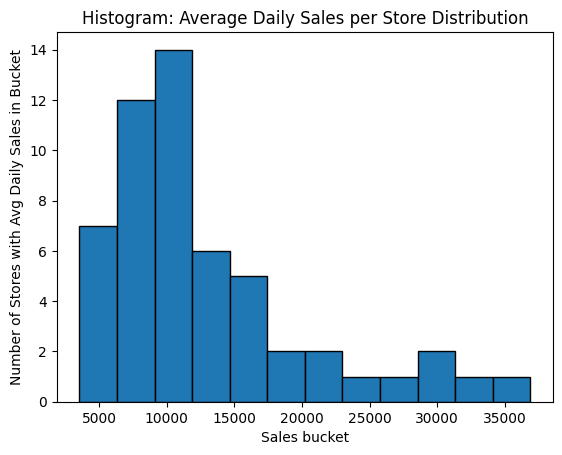

In [716]:
total_sales_per_store_daily = df_train_shortened.groupby(['store_nbr','date'])['sales'].sum().reset_index()
avg_sales_per_store = total_sales_per_store_daily.groupby(['store_nbr'])['sales'].mean().reset_index()
# Plot the bar chart
plt.hist(avg_sales_per_store['sales'], bins = 12, edgecolor = 'black')
plt.xlabel('Sales bucket')
plt.ylabel('Number of Stores with Avg Daily Sales in Bucket')
plt.title('Histogram: Average Daily Sales per Store Distribution')
plt.show()



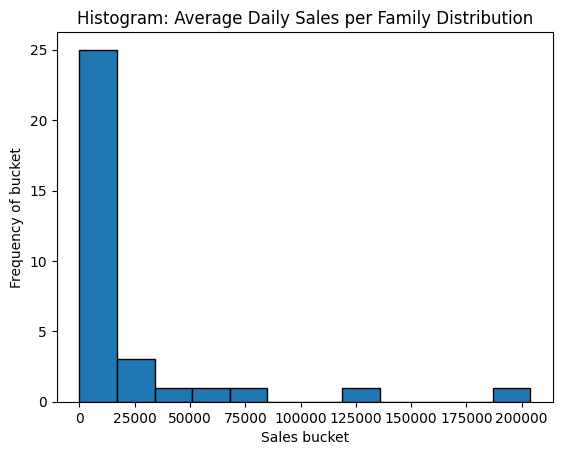

In [263]:
total_sales_per_family_daily = df_train_shortened.groupby(['family','date'])['sales'].sum().reset_index()
avg_sales_per_family = total_sales_per_family_daily.groupby(['family'])['sales'].mean().reset_index()
# Plot the bar chart
plt.hist(avg_sales_per_family['sales'], bins = 12, edgecolor = 'black')
plt.xlabel('Sales bucket')
plt.ylabel('Frequency of bucket')
plt.title('Histogram: Average Daily Sales per Family Distribution')
plt.show()


In [264]:
outlier_families = avg_sales_per_family[avg_sales_per_family['sales']>100000]
outlier_families

,family,sales
3,BEVERAGES,128832.830166
12,GROCERY I,203956.493400


the avg daily sales per store looks like a normal distribution with a right skew. <br> the avg daily sales per family chart has most families grouping on the low sales with 2 huge outliers, beverages and groceries


In [718]:
df_train

,id,date,store_nbr,family,sales,onpromotion,day,day_of_week,day_name,month,year
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,1,1,Tuesday,1,2013
1,1,2013-01-01,1,BABY CARE,0.000,0,1,1,Tuesday,1,2013
2,2,2013-01-01,1,BEAUTY,0.000,0,1,1,Tuesday,1,2013
3,3,2013-01-01,1,BEVERAGES,0.000,0,1,1,Tuesday,1,2013
4,4,2013-01-01,1,BOOKS,0.000,0,1,1,Tuesday,1,2013
...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,15,1,Tuesday,8,2017
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,15,1,Tuesday,8,2017
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,15,1,Tuesday,8,2017
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,15,1,Tuesday,8,2017


C:\Users\Cornelius\AppData\Local\Temp\ipykernel_21644\3358033382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a["ind"] = 1
C:\Users\Cornelius\AppData\Local\Temp\ipykernel_21644\3358033382.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a["ind"] = a.groupby("family").ind.cumsum().values


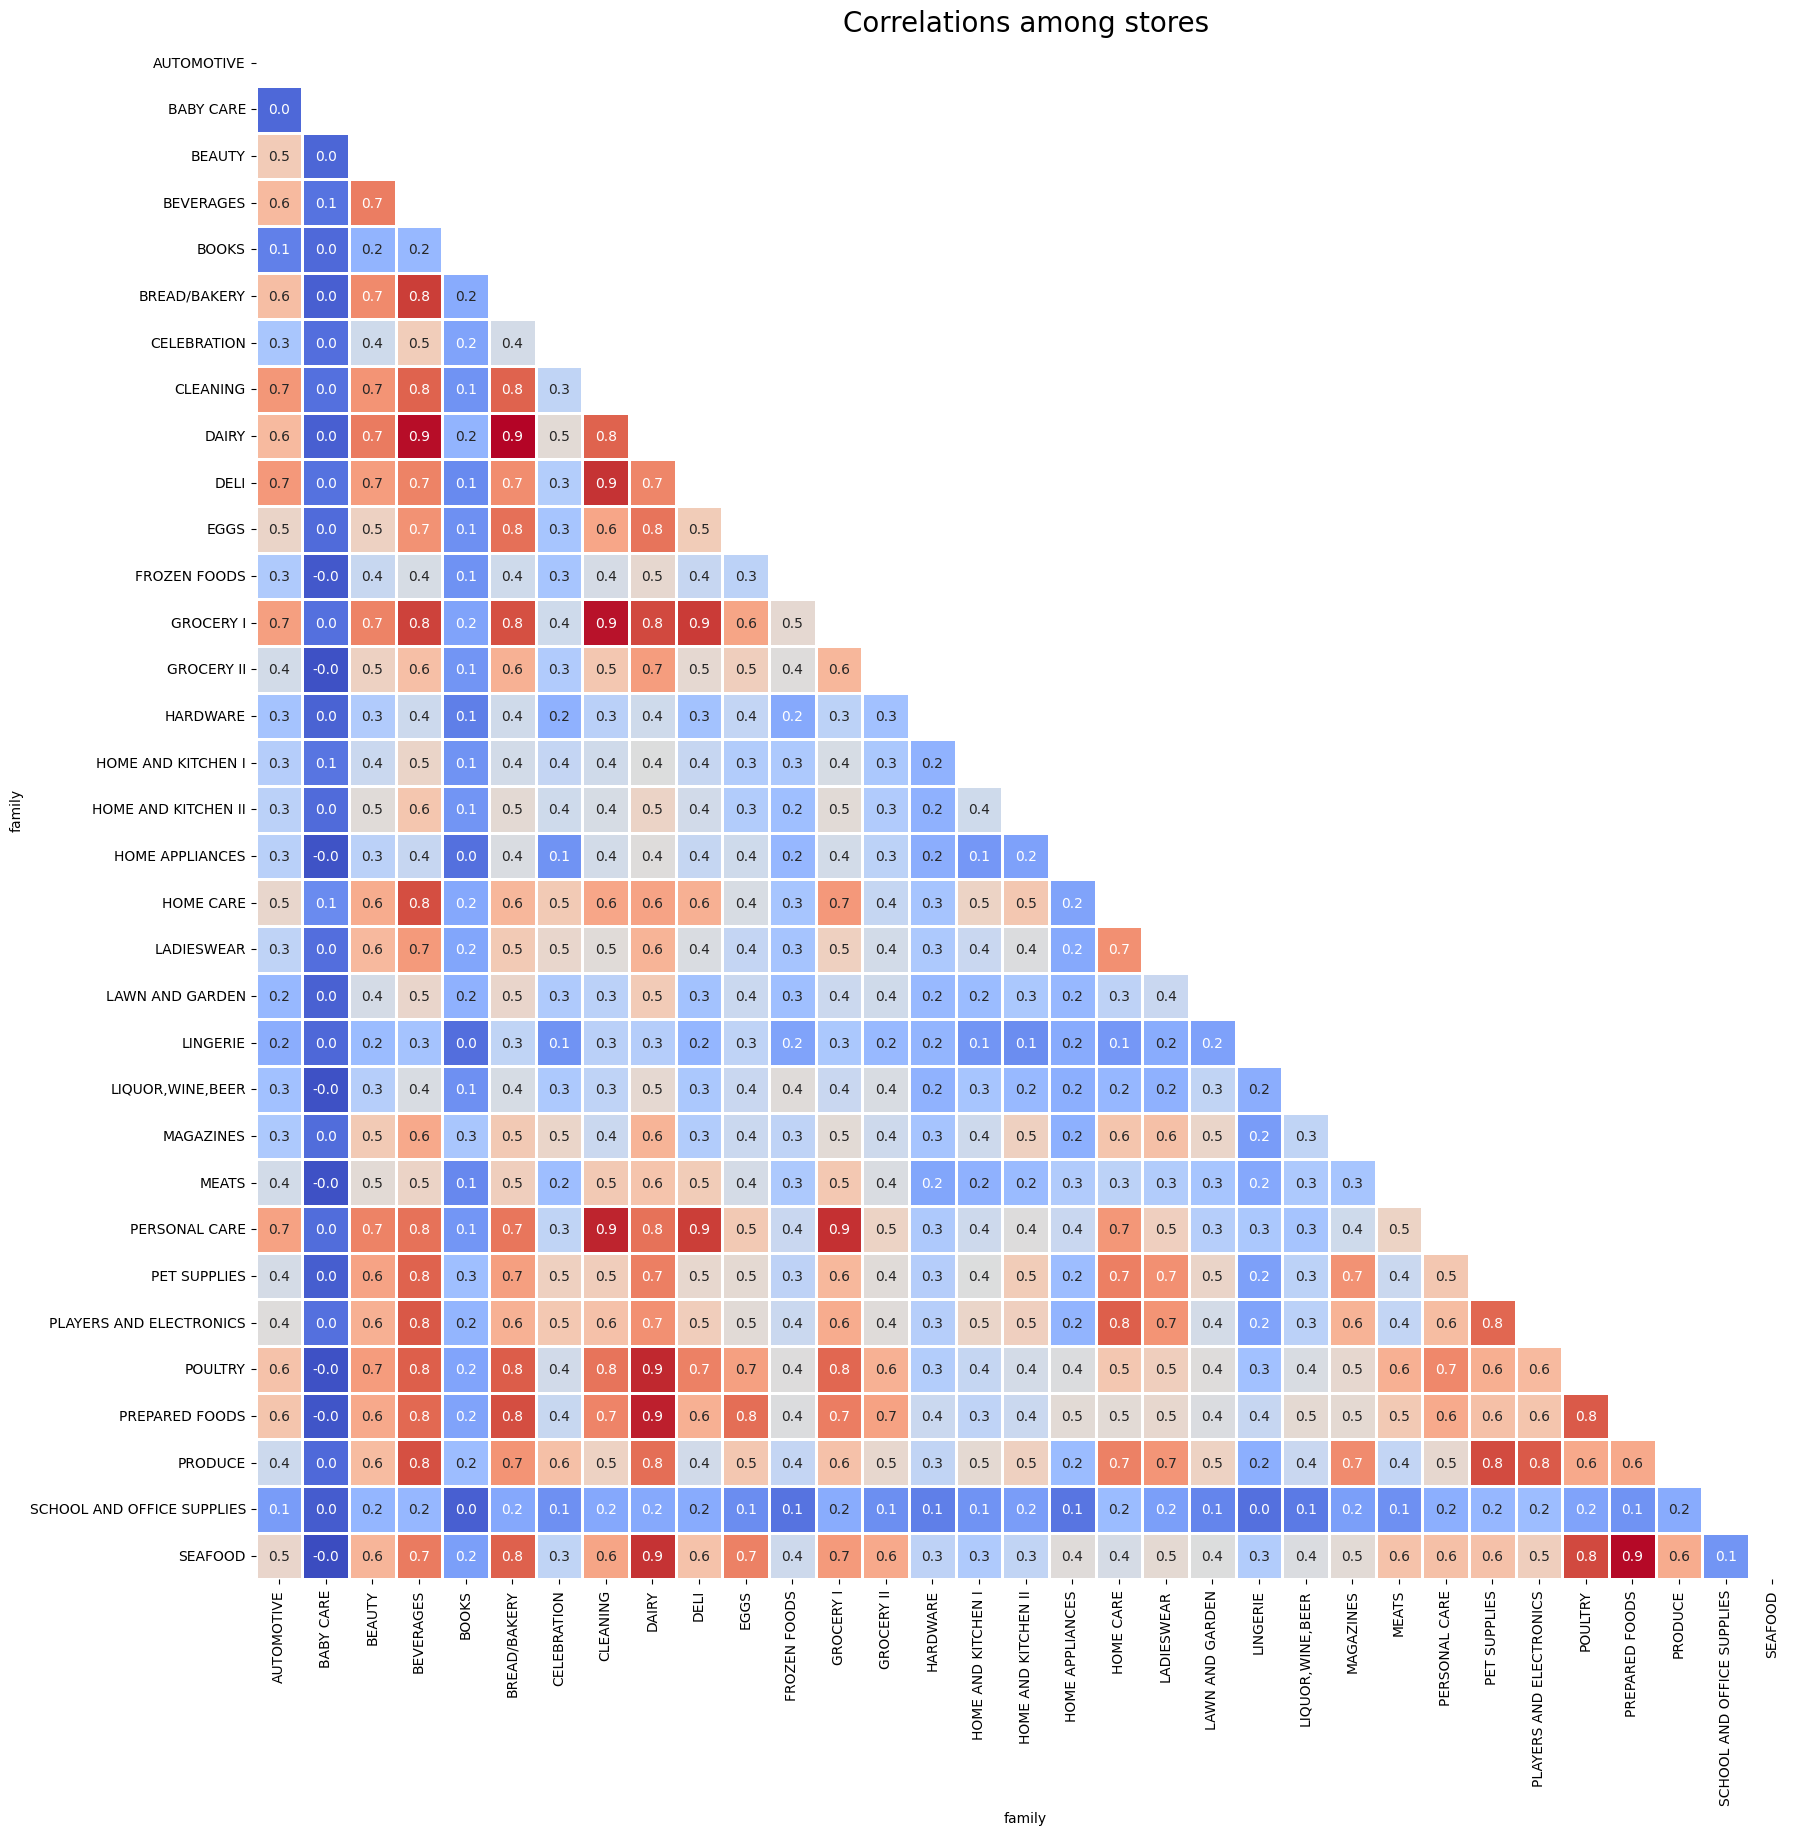

In [720]:
a = df_train[["family", "sales"]]
a["ind"] = 1
a["ind"] = a.groupby("family").ind.cumsum().values
a = pd.pivot(a, index = "ind", columns = "family", values = "sales").corr()
mask = np.triu(a.corr())
plt.figure(figsize=(20, 20))
sns.heatmap(a,
        annot=True,
        fmt='.1f',
        cmap='coolwarm',
        square=True,
        mask=mask,
        linewidths=1,
        cbar=False)
plt.title("Correlations among Families",fontsize = 20)
plt.show()

In [722]:
len(df_train['family'].unique())

33

## Holidays ###

#### clean holidays data

In [466]:
df_holidays['date'] = pd.to_datetime(df_holidays['date'])

In [467]:
# transferred  = True is a holiday that was observed on a different day
df_holidays_real = df_holidays[df_holidays['transferred']==False] 
df_holidays_real['date'].value_counts()

date
2014-06-25    4
2015-06-25    3
2012-06-25    3
2017-06-25    3
2013-06-25    3
             ..
2014-08-05    1
2014-08-10    1
2014-08-15    1
2014-08-24    1
2017-12-26    1
Name: count, Length: 300, dtype: int64

In [492]:

unique_holis2 = df_holidays_real[['description','locale']].drop_duplicates()
unique_holis_national = unique_holis2[unique_holis2['locale']=='National'].drop(['locale'],axis=1)
unique_holis_city = unique_holis2[unique_holis2['locale']=='Local'].drop(['locale'],axis=1)
unique_holis_state = unique_holis2[unique_holis2['locale']=='Regional'].drop(['locale'],axis=1)

In [469]:
#sum up sales per day to analyze holidays
#df_train_summed_daily = df_train_shortened.groupby(['date']).agg({'onpromotion':'sum', 'sales':'sum'}).reset_index()
df_train_summed_daily = df_train_shortened.groupby(['date','city','state']).agg({'onpromotion':'sum', 'sales':'sum'}).reset_index()
df_train_summed_daily

,date,city,state,onpromotion,sales
0,2013-01-01,Salinas,Santa Elena,0,2511.618999
1,2013-01-02,Ambato,Tungurahua,0,23136.469000
2,2013-01-02,Babahoyo,Los Rios,0,6637.560000
3,2013-01-02,Cayambe,Pichincha,0,18329.638000
4,2013-01-02,Cuenca,Azuay,0,21068.210009
...,...,...,...,...,...
35376,2017-08-15,Quevedo,Los Rios,258,11649.571000
35377,2017-08-15,Quito,Pichincha,3334,341655.357968
35378,2017-08-15,Riobamba,Chimborazo,215,9342.732000
35379,2017-08-15,Salinas,Santa Elena,85,6522.788000


In [470]:

national_holidays = df_holidays_real[df_holidays_real['locale']=='National'].loc[:,('date','description')]
local_holidays = df_holidays_real[df_holidays_real['locale']=='Local'].loc[:,('date','description','locale_name')]
state_holidays = df_holidays_real[df_holidays_real['locale']=='Regional'].loc[:,('date','description','locale_name')]

In [521]:
#combine training set with holidays
#df_holi = pd.merge(df_train_summed_daily, national_holidays, how='left', on='date')
#df_holi_state = pd.merge(df_train_summed_daily, state_holidays, how='inner', left_on=['date', 'state'], right_on=['date','locale_name'])
#df_holi_city = pd.merge(df_train_summed_daily, local_holidays, how='inner', left_on=['date', 'city'], right_on=['date','locale_name'])

df_holi = pd.merge(df_train_summed_daily, national_holidays, how='left', on='date')
df_holi = pd.merge(df_holi, state_holidays, how='left', left_on=['date', 'state'], right_on=['date','locale_name'])
df_holi = pd.merge(df_holi, local_holidays, how='left', left_on=['date', 'city'], right_on=['date','locale_name'])

df_holi = df_holi.drop(['locale_name_x','locale_name_y'],axis=1)
df_holi = df_holi.rename(columns = {'description_x':'national_holiday','description_y':'state_holiday','description':'city_holiday'})
#has dups
#now aggregate per city

In [522]:
df_holi

,date,city,state,onpromotion,sales,national_holiday,state_holiday,city_holiday
0,2013-01-01,Salinas,Santa Elena,0,2511.618999,Primer dia del ano,NaN,NaN
1,2013-01-02,Ambato,Tungurahua,0,23136.469000,NaN,NaN,NaN
2,2013-01-02,Babahoyo,Los Rios,0,6637.560000,NaN,NaN,NaN
3,2013-01-02,Cayambe,Pichincha,0,18329.638000,NaN,NaN,NaN
4,2013-01-02,Cuenca,Azuay,0,21068.210009,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
35464,2017-08-15,Quevedo,Los Rios,258,11649.571000,NaN,NaN,NaN
35465,2017-08-15,Quito,Pichincha,3334,341655.357968,NaN,NaN,NaN
35466,2017-08-15,Riobamba,Chimborazo,215,9342.732000,NaN,NaN,Fundacion de Riobamba
35467,2017-08-15,Salinas,Santa Elena,85,6522.788000,NaN,NaN,NaN


In [523]:
#df_holi = pd.merge(df_train_summed_daily, national_holidays, how='left', on='date')
#df_holi = pd.merge(df_holi, state_holidays, how='left', left_on=['date', 'state'], right_on=['date','locale_name'])
##df_holi[(df_holi['date']=='2016-05-07') & (df_holi['state']=='Imbabura') ]
#national_holidays[national_holidays['date']=='2016-05-07']

In [524]:

df_holi[(df_holi['date']=='2016-05-12') & (df_holi['city']=='Puyo') ]
#df_holi[(df_holi['state_holiday'].notnull()) ]

,date,city,state,onpromotion,sales,national_holiday,state_holiday,city_holiday
25364,2016-05-12,Puyo,Pastaza,98,4032.34,Terremoto Manabi+26,NaN,Cantonizacion del Puyo


In [525]:
# joing train to holidays. will create duplicate when a there are multiple holidays falling on same date
#df_holi = pd.merge(df_train_summed_daily, df_holidays_real, on='date', how='left')
#df_holi
# wont need this section anymore


In [526]:
# set boolean column for each unique holiday. still have dups

for holiday in unique_holis_national['description'].tolist():
    df_holi[holiday] = df_holi['national_holiday'] == holiday
for holiday in unique_holis_state['description'].tolist():
    df_holi[holiday] = df_holi['state_holiday'] == holiday
for holiday in unique_holis_city['description'].tolist():
    df_holi[holiday] = df_holi['city_holiday'] == holiday

df_holi = df_holi.drop(['national_holiday','state_holiday','city_holiday'] ,axis=1)


C:\Users\Cornelius\AppData\Local\Temp\ipykernel_21644\3202305570.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_holi[holiday] = df_holi['city_holiday'] == holiday
C:\Users\Cornelius\AppData\Local\Temp\ipykernel_21644\3202305570.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_holi[holiday] = df_holi['city_holiday'] == holiday
C:\Users\Cornelius\AppData\Local\Temp\ipykernel_21644\3202305570.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

,date,city,state,onpromotion,sales,Primer Grito de Independencia,Traslado Independencia de Guayaquil,Dia de Difuntos,Independencia de Cuenca,Navidad-4,...,Independencia de Latacunga,Independencia de Ambato,Fundacion de Quito-1,Fundacion de Quito,Fundacion de Loja,Cantonizacion de Salinas,Fundacion de Guayaquil-1,Fundacion de Guayaquil,Traslado Fundacion de Guayaquil,Traslado Fundacion de Quito
0,2013-01-01,Salinas,Santa Elena,0,2511.618999,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2013-01-02,Ambato,Tungurahua,0,23136.469000,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2013-01-02,Babahoyo,Los Rios,0,6637.560000,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2013-01-02,Cayambe,Pichincha,0,18329.638000,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2013-01-02,Cuenca,Azuay,0,21068.210009,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35464,2017-08-15,Quevedo,Los Rios,258,11649.571000,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
35465,2017-08-15,Quito,Pichincha,3334,341655.357968,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
35466,2017-08-15,Riobamba,Chimborazo,215,9342.732000,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
35467,2017-08-15,Salinas,Santa Elena,85,6522.788000,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [527]:
df_holi

,date,city,state,onpromotion,sales,Primer Grito de Independencia,Traslado Independencia de Guayaquil,Dia de Difuntos,Independencia de Cuenca,Navidad-4,...,Independencia de Latacunga,Independencia de Ambato,Fundacion de Quito-1,Fundacion de Quito,Fundacion de Loja,Cantonizacion de Salinas,Fundacion de Guayaquil-1,Fundacion de Guayaquil,Traslado Fundacion de Guayaquil,Traslado Fundacion de Quito
0,2013-01-01,Salinas,Santa Elena,0,2511.618999,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2013-01-02,Ambato,Tungurahua,0,23136.469000,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2013-01-02,Babahoyo,Los Rios,0,6637.560000,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2013-01-02,Cayambe,Pichincha,0,18329.638000,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2013-01-02,Cuenca,Azuay,0,21068.210009,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35464,2017-08-15,Quevedo,Los Rios,258,11649.571000,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
35465,2017-08-15,Quito,Pichincha,3334,341655.357968,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
35466,2017-08-15,Riobamba,Chimborazo,215,9342.732000,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
35467,2017-08-15,Salinas,Santa Elena,85,6522.788000,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [543]:
#example dup
a = df_holi[(df_holi['date']=='2016-05-07')& (df_holi['city']=='Ambato')]
a.iloc[:,60:80]
#a['Dia de la Madre-1']
#df_holi.iloc[35466,15:40]


,Terremoto Manabi+19,Terremoto Manabi+20,Terremoto Manabi+21,Terremoto Manabi+22,Terremoto Manabi+23,Terremoto Manabi+24,Terremoto Manabi+25,Terremoto Manabi+26,Terremoto Manabi+27,Terremoto Manabi+28,Terremoto Manabi+29,Terremoto Manabi+30,Traslado Batalla de Pichincha,Traslado Primer Grito de Independencia,Puente Dia de Difuntos,Recupero Puente Dia de Difuntos,Traslado Primer dia del ano,Provincializacion de Cotopaxi,Provincializacion de Imbabura,Provincializacion de Santo Domingo
25194,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
25195,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [338]:
#find days with multiple holidays
#df_holi_dup_test = df_holidays_real.groupby('date').size().reset_index(name='count')
#df_holi_dup_test = df_holi_dup_test[df_holi_dup_test['count'] > 1]
#df_holi_dup_test.sort_values(by='count')

In [ ]:
#df_holi_summed_daily = df_holi.groupby(['date','city','state', 'description']).agg({'onpromotion':'sum', 'sales':'sum'}).reset_index()
# i think not necessary anymore

In [569]:
# combines duplicates rows into 1 rows where there is a true for each holiday that falls on the given date
unique_holis_list = list(unique_holis)
agg_func = {col: 'any' for col in unique_holis_list}
aggregated_df = df_holi.groupby(['date','sales','city','state','onpromotion']).agg(agg_func).reset_index()
aggregated_df = pd.get_dummies(aggregated_df, columns=['city', 'state'], prefix=['city', 'state'])

In [570]:
a = aggregated_df[(aggregated_df['date']=='2016-05-07')& (aggregated_df['city_Ambato']==1)]
b = a['Dia de la Madre-1']
c = a['Terremoto Manabi+21']
a

,date,sales,onpromotion,Fundacion de Manta,Provincializacion de Cotopaxi,Fundacion de Cuenca,Cantonizacion de Libertad,Cantonizacion de Riobamba,Cantonizacion del Puyo,Cantonizacion de Guaranda,...,state_Guayas,state_Imbabura,state_Loja,state_Los Rios,state_Manabi,state_Pastaza,state_Pichincha,state_Santa Elena,state_Santo Domingo de los Tsachilas,state_Tungurahua
25169,2016-05-07,37335.21199,236,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


#### OLS to determine impact of each holiday across all stores

In [605]:
#testing a date that has multiple holidays
aggregated_df[aggregated_df['Independencia de Cuenca']]

,date,sales,onpromotion,Fundacion de Manta,Provincializacion de Cotopaxi,Fundacion de Cuenca,Cantonizacion de Libertad,Cantonizacion de Riobamba,Cantonizacion del Puyo,Cantonizacion de Guaranda,...,state_Guayas,state_Imbabura,state_Loja,state_Los Rios,state_Manabi,state_Pastaza,state_Pichincha,state_Santa Elena,state_Santo Domingo de los Tsachilas,state_Tungurahua
5974,2013-11-03,3287.656996,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
5975,2013-11-03,3868.299000,0,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
5976,2013-11-03,4878.991000,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5977,2013-11-03,5796.929000,0,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
5978,2013-11-03,6146.693000,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29128,2016-11-03,29069.402002,853,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
29129,2016-11-03,32596.297000,502,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
29130,2016-11-03,36475.802000,790,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
29131,2016-11-03,76254.005005,2055,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


In [596]:
#aggregated_df_ols = df_holi.groupby(['date','onpromotion']).agg(agg_func).reset_index()
# cant remember if this was used...

In [597]:
# sum everything for the date, not analyzing if holidays impact store or family bc it produces too many variables for OLS
# aggregated_df_ols = aggregated_df.drop(['family','store_nbr'],axis=1)
# believe this is obsoleted

In [598]:
# seasonality has big impact on predicted sales so need to add some variables to capture 
aggregated_df_ols = aggregated_df.copy()
aggregated_df_ols['dow'] = aggregated_df_ols['date'].dt.dayofweek
aggregated_df_ols['month'] = aggregated_df_ols['date'].dt.month
aggregated_df_ols['year'] = aggregated_df_ols['date'].dt.year
aggregated_df_ols = aggregated_df_ols.drop('date',axis=1)

In [599]:
#model seasonality with dummy vars... do i need this?
aggregated_df_ols_dummies =  pd.get_dummies(aggregated_df_ols, columns=['dow','month', 'year'], drop_first=True)

In [600]:
X = aggregated_df_ols_dummies.drop('sales',axis=1)
# add constant for linear regression
X = sm.add_constant(X)
X = X.astype(int)
y=aggregated_df_ols_dummies['sales']

In [644]:
print(X.shape, X.shape[0],'rows and', X.shape[1], 'columns.  OLS conditions are met (10-20x rows for each column)')

(35381, 164) 35381 rows and 164 columns.  OLS conditions are met (10-20x rows for each column)


In [606]:
model_OLS = sm.OLS(y,X).fit()

In [697]:
model_summary = model_OLS.summary()
print(model_summary)
#p values less then .05 are significant

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     2129.
Date:                Sun, 04 Feb 2024   Prob (F-statistic):               0.00
Time:                        17:15:51   Log-Likelihood:            -4.0693e+05
No. Observations:               35381   AIC:                         8.142e+05
Df Residuals:                   35236   BIC:                         8.154e+05
Df Model:                         144                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

In [702]:
# Get the summary results as a DataFrame
summary_df = pd.read_html(model_summary.tables[1].as_html(), header=0, index_col=0)[0]
summary_df.to_csv('ols_summary_results.csv')

C:\Users\Cornelius\AppData\Local\Temp\ipykernel_21644\3083454509.py:2: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  summary_df = pd.read_html(model_summary.tables[1].as_html(), header=0, index_col=0)[0]


In [701]:
#! pip install lxml

In [696]:
# remove features that have p value >.10 
# ... no xmas day in trainset
pvalues = model_OLS.pvalues
alpha = .05
drop_columns = pvalues[pvalues>alpha]
drop_cols = list(drop_columns.index)
# manually keeping non holiday columns
#most date columns were significant except for these 3 months. still would like to keep so there arent holes in date
drop_cols.remove('month_3')
drop_cols.remove('month_7')
drop_cols.remove('month_9')
drop_cols.remove('month_10')
drop_cols.remove('month_11')
drop_cols.remove('city_Ambato')
drop_cols.remove('state_Tungurahua')
drop_cols.remove('state_Guayas')

#train_data.drop(columns=drop_cols)
print(len(drop_cols), 'holidays droped out of', len(unique_holis),'.', len(unique_holis)-len(drop_cols) ,'unique holidays remain' )

83 holidays droped out of 103 . 20 unique holidays remain


In [609]:
df_holi_shortened = df_holidays_real[~df_holidays_real['description'].isin(drop_cols)]
df_holi_shortened = df_holi_shortened.drop(['type','locale','locale_name','transferred'],axis=1)
df_holi_shortened

,date,description
22,2012-11-03,Independencia de Cuenca
29,2012-12-06,Fundacion de Quito
31,2012-12-21,Navidad-4
33,2012-12-22,Navidad-3
34,2012-12-23,Navidad-2
...,...,...
333,2017-11-03,Independencia de Cuenca
343,2017-12-21,Navidad-4
345,2017-12-22,Navidad-3
346,2017-12-23,Navidad-2


In [618]:
#338 to 108 holidays. 15 unique holidays. some holidays are outside of train and test date range
df_holi_shortened['description'].value_counts().sort_values(ascending=False)

description
Carnaval                                   10
Navidad-4                                   6
Navidad-3                                   6
Navidad-2                                   6
Navidad-1                                   6
Independencia de Cuenca                     6
Primer dia del ano-1                        5
Dia del Trabajo                             5
Dia de la Madre                             5
Fundacion de Quito                          5
Primer dia del ano                          4
Mundial de futbol Brasil: Ecuador-Suiza     1
Recupero Puente Primer dia del ano          1
Terremoto Manabi+1                          1
Terremoto Manabi+2                          1
Terremoto Manabi+3                          1
Terremoto Manabi+4                          1
Terremoto Manabi+5                          1
Terremoto Manabi+6                          1
Terremoto Manabi+7                          1
Terremoto Manabi+16                         1
Traslado Primer dia de

#### redone train set with holidays ####

In [619]:
# still have dates with multiple holidays 
# 2017-12-22 has two holidays
# no longer have dups once holidays have been removed
df_holi_shortened['date'].value_counts().sort_values(ascending=False)

date
2012-11-03    1
2014-01-01    1
2012-12-21    1
2012-12-22    1
2012-12-23    1
             ..
2017-11-03    1
2017-12-21    1
2017-12-22    1
2017-12-23    1
2017-12-24    1
Name: count, Length: 75, dtype: int64

In [287]:
unique_holidays = df_holi_shortened['description'].unique()
sorted(unique_holidays)


['Cantonizacion de El Carmen',
 'Cantonizacion de Salinas',
 'Carnaval',
 'Dia de la Madre',
 'Dia del Trabajo',
 'Fundacion de Santo Domingo',
 'Independencia de Cuenca',
 'Independencia de Guayaquil',
 'Mundial de futbol Brasil: Ecuador-Suiza',
 'Navidad-1',
 'Navidad-2',
 'Navidad-3',
 'Navidad-4',
 'Primer dia del ano',
 'Primer dia del ano-1',
 'Provincializacion de Cotopaxi',
 'Recupero Puente Primer dia del ano',
 'Terremoto Manabi+1',
 'Terremoto Manabi+14',
 'Terremoto Manabi+16',
 'Terremoto Manabi+2',
 'Terremoto Manabi+21',
 'Terremoto Manabi+3',
 'Terremoto Manabi+4',
 'Terremoto Manabi+5',
 'Terremoto Manabi+6',
 'Terremoto Manabi+7',
 'Traslado Batalla de Pichincha',
 'Traslado Primer dia del ano']

In [625]:
filtered_holidays = df_holidays[df_holidays['description'].isin(unique_holidays)]
filtered_holidays

,date,type,locale,locale_name,description,transferred
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
10,2012-07-03,Holiday,Local,Santo Domingo,Fundacion de Santo Domingo,False
11,2012-07-03,Holiday,Local,El Carmen,Cantonizacion de El Carmen,False
19,2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
22,2012-11-03,Holiday,National,Ecuador,Independencia de Cuenca,False
...,...,...,...,...,...,...
343,2017-12-21,Additional,National,Ecuador,Navidad-4,False
344,2017-12-22,Holiday,Local,Salinas,Cantonizacion de Salinas,False
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False


In [626]:
#separate these out because they have differenct merge conditions
national_holidays_filtered = filtered_holidays[filtered_holidays['locale']=='National'].loc[:,('date','description')]
local_holidays_filtered = filtered_holidays[filtered_holidays['locale']=='Local'].loc[:,('date','description','locale_name')]
state_holidays_filtered = filtered_holidays[filtered_holidays['locale']=='Regional'].loc[:,('date','description','locale_name')]

In [653]:
df_train_shortened

,id,date,store_nbr,family,sales,onpromotion,day,day_of_week,day_name,month,year
33,1782,2013-01-02,1,AUTOMOTIVE,2.000,0,2,2,Wednesday,1,2013
34,1783,2013-01-02,1,BABY CARE,0.000,0,2,2,Wednesday,1,2013
35,1784,2013-01-02,1,BEAUTY,2.000,0,2,2,Wednesday,1,2013
36,1785,2013-01-02,1,BEVERAGES,1091.000,0,2,2,Wednesday,1,2013
37,1786,2013-01-02,1,BOOKS,0.000,0,2,2,Wednesday,1,2013
...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,15,1,Tuesday,8,2017
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,15,1,Tuesday,8,2017
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,15,1,Tuesday,8,2017
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,15,1,Tuesday,8,2017


In [671]:
def train_to_holiday_merge(train, national_holidays_filtered, state_holidays_filtered, local_holidays_filtered):
    train['date'] = pd.to_datetime(train['date'])
    df_train_filtered = pd.merge(train, national_holidays_filtered, how='left', on='date')
    df_train_filtered = pd.merge(df_train_filtered, state_holidays_filtered, how='left', left_on=['date', 'state'], right_on=['date','locale_name'])
    df_train_filtered = pd.merge(df_train_filtered, local_holidays_filtered, how='left', left_on=['date', 'city'], right_on=['date','locale_name'])
    df_train_filtered['holiday'] = df_train_filtered['description_x'].combine_first(df_train_filtered['description_y']).combine_first(df_train_filtered['description'])

    df_train_filtered = df_train_filtered.drop(['locale_name_x','locale_name_y','description','description_x','description_y'],axis=1)
    return df_train_filtered
df_train_filtered = train_to_holiday_merge(df_train_shortened, national_holidays_filtered, state_holidays_filtered,local_holidays_filtered)
df_train_filtered[df_train_filtered['date']=='2015-12-22']
#df_holi = df_holi.rename(columns = {'description_x':'national_holiday','description_y':'state_holiday','description':'city_holiday'})

,id,date,store_nbr,family,sales,onpromotion,day,day_of_week,day_name,month,year,city,state,type,cluster,holiday
35706,1929906,2015-12-22,1,AUTOMOTIVE,9.000,0,22,1,Tuesday,12,2015,Quito,Pichincha,D,13,Navidad-3
35707,1929907,2015-12-22,1,BABY CARE,0.000,0,22,1,Tuesday,12,2015,Quito,Pichincha,D,13,Navidad-3
35708,1929908,2015-12-22,1,BEAUTY,3.000,0,22,1,Tuesday,12,2015,Quito,Pichincha,D,13,Navidad-3
35709,1929909,2015-12-22,1,BEVERAGES,2344.000,18,22,1,Tuesday,12,2015,Quito,Pichincha,D,13,Navidad-3
35710,1929910,2015-12-22,1,BOOKS,0.000,0,22,1,Tuesday,12,2015,Quito,Pichincha,D,13,Navidad-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759026,1931683,2015-12-22,9,POULTRY,486.514,0,22,1,Tuesday,12,2015,Quito,Pichincha,B,6,Navidad-3
2759027,1931684,2015-12-22,9,PREPARED FOODS,85.006,1,22,1,Tuesday,12,2015,Quito,Pichincha,B,6,Navidad-3
2759028,1931685,2015-12-22,9,PRODUCE,2531.693,137,22,1,Tuesday,12,2015,Quito,Pichincha,B,6,Navidad-3
2759029,1931686,2015-12-22,9,SCHOOL AND OFFICE SUPPLIES,0.000,0,22,1,Tuesday,12,2015,Quito,Pichincha,B,6,Navidad-3


# set boolean column for each unique holiday
df_holiday_shortened = df_holi_shortened.copy()
for holiday in unique_holidays:
    df_holiday_shortened[holiday] = df_holiday_shortened['description'] == holiday
#df_holiday_shortened = df_holiday_shortened.drop('description', axis=1)
#dont drop description yet. might be useful later if we dont wanna use extended columns


unique_holidays_list = list(unique_holidays)
agg_func = {col: 'any' for col in unique_holidays_list}
df_holiday_shortened = df_holiday_shortened.groupby(['date']).agg(agg_func).reset_index()
df_holiday_shortened

## store groupings ##

In [291]:
df_stores
#54 stores, 17 clusters

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


## final df ##

In [681]:
train_final = train_to_holiday_merge(df_train_shortened, national_holidays_filtered, state_holidays_filtered, local_holidays_filtered)
train_final

,id,date,store_nbr,family,sales,onpromotion,day,day_of_week,day_name,month,year,city,state,type,cluster,holiday
0,1782,2013-01-02,1,AUTOMOTIVE,2.000,0,2,2,Wednesday,1,2013,Quito,Pichincha,D,13,NaN
1,1783,2013-01-02,1,BABY CARE,0.000,0,2,2,Wednesday,1,2013,Quito,Pichincha,D,13,NaN
2,1784,2013-01-02,1,BEAUTY,2.000,0,2,2,Wednesday,1,2013,Quito,Pichincha,D,13,NaN
3,1785,2013-01-02,1,BEVERAGES,1091.000,0,2,2,Wednesday,1,2013,Quito,Pichincha,D,13,NaN
4,1786,2013-01-02,1,BOOKS,0.000,0,2,2,Wednesday,1,2013,Quito,Pichincha,D,13,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2778826,3000883,2017-08-15,9,POULTRY,438.133,0,15,1,Tuesday,8,2017,Quito,Pichincha,B,6,NaN
2778827,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,15,1,Tuesday,8,2017,Quito,Pichincha,B,6,NaN
2778828,3000885,2017-08-15,9,PRODUCE,2419.729,148,15,1,Tuesday,8,2017,Quito,Pichincha,B,6,NaN
2778829,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,15,1,Tuesday,8,2017,Quito,Pichincha,B,6,NaN


In [672]:
df_test_transformed = train_to_store_merge(df_test, df_stores)
df_test_transformed = train_to_holiday_merge(df_test_transformed, national_holidays_filtered, state_holidays_filtered, local_holidays_filtered)
df_test_transformed

,id,date,store_nbr,family,onpromotion,city,state,type,cluster,holiday
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,NaN
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,NaN
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,NaN
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,NaN
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,NaN
...,...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1,Quito,Pichincha,B,6,NaN
28508,3029396,2017-08-31,9,PREPARED FOODS,0,Quito,Pichincha,B,6,NaN
28509,3029397,2017-08-31,9,PRODUCE,1,Quito,Pichincha,B,6,NaN
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,Quito,Pichincha,B,6,NaN
